### Imports

In [25]:
import pandas as pd
import os
import numpy as np
from functools import reduce
import missingno as msno
import matplotlib.pyplot as plt
import seaborn
import threading
from IPython.display import Image

In [26]:
import yfinance as yf

### Rate Limitation

#### There’re some limitations by making the call to Yahoo Finance API:

#### Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).

## DEFINE DEPENDENT ASSET

Text(0, 0.5, '$USD')

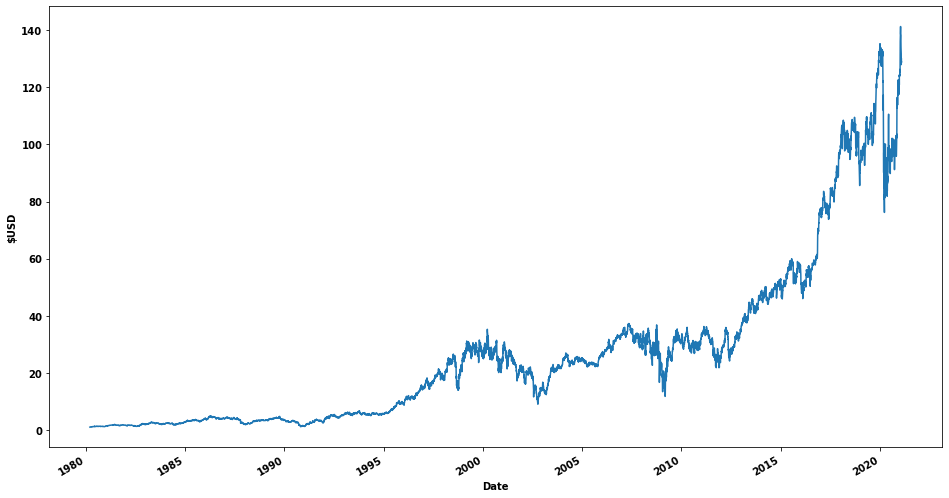

In [27]:
msft = yf.Ticker("JPM")

# get historical market data
hist = msft.history(period="max")

ax = hist['Close'].plot(figsize=(16, 9))
ax.set_xlabel("Date")
ax.set_ylabel("$USD")

In [28]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-03-17,0.0,1.200617,1.174611,1.178945,62775,0.0,0.0
1980-03-18,0.0,1.196282,1.178944,1.187613,64125,0.0,0.0
1980-03-19,0.0,1.209285,1.196282,1.204951,40500,0.0,0.0
1980-03-20,0.0,1.204951,1.191948,1.196282,18900,0.0,0.0
1980-03-21,0.0,1.222288,1.196282,1.222288,97200,0.0,0.0


## PICK CORRELATED ASSETS

##### NYSE Related Assets

In [29]:
correlated_assets = {
  'JPMorgan': 'JPM',
  'Goldman Sachs': 'GS',
  'Morgan Stanley': 'MS',
  'Wells Fargo': 'WFC',
  'Bank of America': 'BCS',
  'Barclays': 'BCS',
  'Deutche Bank': 'DB',
  'Citigroup': 'C',
  'Credit Suisse': 'DHY',
  'UBS Group': 'UBS',
  'HSBC Holdings': 'HSBC'
}

total_assets = len(correlated_assets)

1500/total_assets

136.36363636363637

#### ~120 requests per hour per asset

#### 2 / minute

## Sliding Window Backtest
![title](data/time_series_split.jpg)

In [52]:
class FetchFinancials(object):
  def __init__(self, assets, dependent):
    """
      Yahoo! Finance Data
      
      Date	Open	High	Low	Close*	Adj Close**	Volumen  
    """
    super().__init__()
    self.assets = assets
    self.dependent = dependent
    self.dataframes = []
  def _fetch(self):
    """
      Fetch Data Twice Every 30 seconds
      
      Returns:
        data: dataframe
    """
    
    # GRAB DATA
    for _ticker in self.assets:
      try:
        ticker = yf.Ticker(_ticker)

        # Historical Market Data
        result = msft.history(period="max")

        for _val in [i for i in result.columns.tolist() if i not in 'Date']:
          result.rename(columns={_val: f'{_ticker}_{_val}'}, inplace=True)

        self.dataframes.append(result)
      except:
        print(f"{_ticker}: ERROR")
      
    # Outer Join on Date
    data = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), self.dataframes)
    
    return data
    
#   def _continuous_fetch(self, interval):
#     """
#       Continuous Fetching of Data using Threading
#     """
    
#     def __continuous_fetch():
#       threading.Timer(30.0, self._continuous_fetch).start()
#       self.data = self._fetch()
      
#     __continuous_fetch()
    
  def _calculate_technical_analysis_indicators(self, dataset):
    dataset.rename(columns={self.dependent: 'price'}, inplace=True)
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['price'].rolling(window=21).mean()

    # Create MACD
    dataset['26ema'] = dataset['price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['price'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['price'].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['price'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = dataset['price']-1

    dataset['log_momentum'] = np.log1p(dataset['price'])
    
    return dataset
    
  def _clean_data(self, dataset):
    """
      Scales Data (-1,1)

      Args:
        data (pd.DataFrame())

      Returns:
        dataframe
    """
    dataset = self._calculate_technical_analysis_indicators(dataset)
    
    minimum=min(dataset.index).date()
    maximum=max(dataset.index).date()

    idx = pd.date_range(minimum,maximum)
    dataset = dataset.reindex(idx, fill_value=np.nan)

    for val in dataset.columns.tolist():
      dataset[val].interpolate(method='linear', inplace=True)
      scaler = MinMaxScaler(feature_range=(-1, 1))
      dataset[val] = scaler.fit_transform(dataset[val].values.reshape(-1,1))
      
    return dataset

In [54]:
assets = list(correlated_assets.values())

grab_data = FetchFinancials(assets, 'JPM_Close')
data = grab_data._fetch()
data = grab_data._calculate_technical_analysis_indicators(data)
data = grab_data._clean_data(data)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['price'] = scaler.fit_transform(price['price'].values.reshape(-1,1))